# Курсовой проект.

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Сдать проект нужно в течение 7 дней после окончания последнего вебинара.
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
3. Необходимо получить R2 > 0.6 на Private Leaderboard.
4. Укажите свой ник на kaggle 


Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров. 

**План занятия**
* [Загрузка данных](#load)
* [1. EDA](#eda)
* [2. Обработка выбросов](#outlier)
* [3. Обработка пропусков](#nan)
* [4. Построение новых признаков](#feature)
* [5. Отбор признаков](#feature_selection)
* [6. Разбиение на train и test](#split)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)

**Подключение библиотек и скриптов**

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


In [7]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
matplotlib.rcParams.update({'font.size': 14})

In [10]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [11]:
TRAIN_DATASET_PATH = '../input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '../input/real-estate-price-prediction-moscow/test.csv'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [12]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [13]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [14]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [15]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


### Приведение типов

In [16]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [17]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. EDA  <a class='anchor' id='eda'>
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

**Целевая переменная**

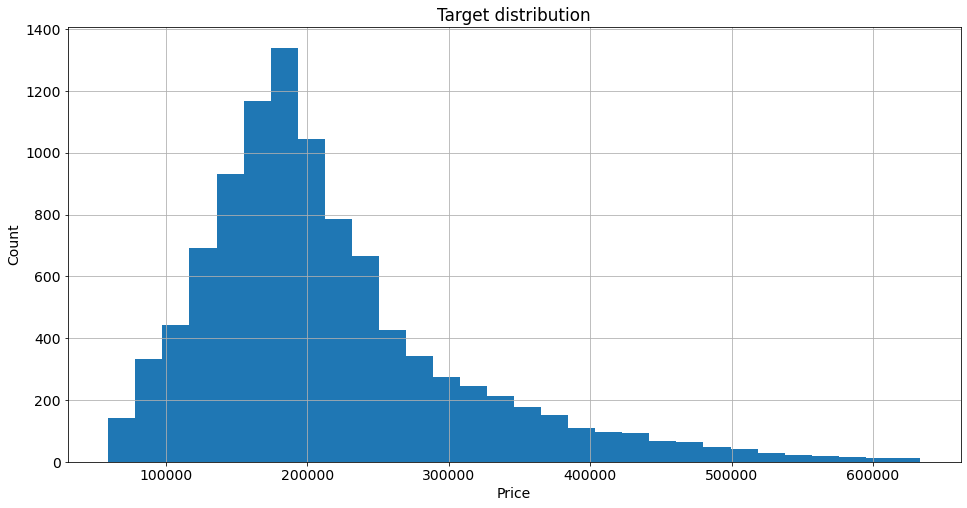

In [18]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Распределение целевой переменной близко к нормальному. Выбросы, возможно, есть, однако в реальности вполне встречаются очень дорогие квартиры

**Количественные переменные**

In [19]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


NaN содержатся в двух признаках: LifeSquare и Healthcare_1

Выбросы по минимальному и максимальному значению: Rooms, Square, LifeSquare, Floor


**Номинативные переменные**

In [20]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [21]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
196      1
199      1
174      1
207      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [22]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [23]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [24]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 2. Обработка выбросов  <a class='anchor' id='outlier'>
Что можно делать с ними?
1. Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем)
2. Заменять выбросы разными методами (медианы, средние значения, np.clip и т.д.)
3. Делать/не делать дополнительную фичу
4. Ничего не делать

In [25]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Rooms**

In [26]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

если в квартире 0 комнат, то делаем 1 комнату, если больше 6 комнат, то делаем число комнат, равным медиане

In [27]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1

train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [28]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**Square**

In [29]:
train_df['Square'].sort_values()

7470      1.136859
4496      1.988943
9869      2.377248
8572      2.596351
161       2.954309
           ...    
7644    212.932361
1906    275.645284
7010    409.425181
726     604.705972
9229    641.065193
Name: Square, Length: 10000, dtype: float64

In [30]:
train_df['Square'].quantile(.975), train_df['Square'].quantile(.025)

(100.90624548226137, 32.10518291149681)

Квантили не очень подходят для определения границ замены значений, поскольку в реальности существуют квартиры с огромной площадью. Но все же квартиры с площадью больше 200 кв м с большой вероятностью окажутся выбросными. Заменим неоправданно большие площади на медиану, а неоправданно маленькие на значение 28 (примерная минимальная площадь жилой квартиры)

In [31]:
train_df.loc[train_df['Square'] > 200, 'Square'] = train_df['Square'].median()

train_df.loc[train_df['Square'] < 28, 'Square'] = 28

In [32]:
train_df['Square'].value_counts()

28.000000    62
52.513310     6
66.496862     1
72.953912     1
35.558981     1
             ..
86.915187     1
82.482521     1
43.112986     1
49.899252     1
80.315047     1
Name: Square, Length: 9934, dtype: int64

**KitchenSquare** 

In [33]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

In [34]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

Площадь кухни меньше 3 кв м неадекватна, поэтому приравниваем площадь трем во всех таких случаях. Выше квантиля 0,975 приравниваем площадь медиане.

In [35]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [36]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

In [37]:
(train_df['KitchenSquare'] > train_df['Square']).sum()

0

После преобразований не осталось квартир, в которых кухня по площади больше всей квартиры

**HouseFloor, Floor**

In [38]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [39]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [40]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [41]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [42]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [43]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [44]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [45]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

после преобразований не осталось квартир, которые находились бы на несуществующем в доме этаже

**HouseYear**

In [46]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [47]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### 3. Обработка пропусков  <a class='anchor' id='nan'>

In [48]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

**LifeSquare**

In [49]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

In [50]:
(train_df['LifeSquare'] > train_df['Square']).sum()

474

После всех преобразований осталось 474 квартиры, в которых жилая площадь больше площади квартиры. В этом случае тоже приавняем площадь выражению: площадь кв минус площадь кухни минус 3

In [51]:
condition = train_df['LifeSquare'] > train_df['Square']
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3
(train_df['LifeSquare'] > train_df['Square']).sum()

0

**Healthcare_1**

У данного показателя много пропущенных значений, однако есть предположение, что он может находиться в зависимости от показателя Helthcare_2

In [52]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.887600,56.161899,39.283009,6.238200,7.407200,12.95910,1984.872400,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.001200,0.182500,0.211300
std,0.811438,18.807857,18.944207,2.794717,5.027814,6.44346,18.416347,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.034622,0.386275,0.408251
min,1.000000,28.000000,0.370619,3.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,1.000000,41.774881,25.038231,3.000000,3.000000,9.00000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.000000,0.000000,0.000000
50%,2.000000,52.513040,35.020639,6.000000,6.000000,13.00000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,0.000000,0.000000
75%,2.000000,65.879387,48.282456,8.000000,11.000000,17.00000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.000000,0.000000,0.000000
max,5.000000,198.930182,165.649522,13.000000,42.000000,117.00000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000


In [53]:
df_cat = train_df.groupby('Helthcare_2', as_index=False).median()[['Helthcare_2', 'Healthcare_1']]
df_cat = pd.DataFrame(df_cat)
df_cat


,Helthcare_2,Healthcare_1
0,0,540.0
1,1,620.0
2,2,750.0
3,3,1145.0
4,4,1894.0
5,5,1575.0
6,6,645.0


Если сгруппировать по Helthcare_2 и вычислить медиану Healthcare_1, то получим 7 групп с относительно разными величинами Helthcare_1. можно попробовать заменить пустые значения данными величинами

In [54]:
d = train_df['Helthcare_2']
d = pd.DataFrame(d)
d = d.merge(df_cat, on=['Helthcare_2'], how="left")
d

,Helthcare_2,Healthcare_1
0,0,540.0
1,1,620.0
2,3,1145.0
3,0,540.0
4,0,540.0
...,...,...
9995,1,620.0
9996,0,540.0
9997,1,620.0
9998,3,1145.0


In [55]:
train_df['Healthcare_1_nan'] = train_df['Healthcare_1'].isna() * 1
train_df = train_df.fillna(d)

In [56]:
train_df.loc[train_df['Healthcare_1_nan']==1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,540.0,0,0,B,305018.871089,0,0,1,1
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,540.0,0,1,B,168106.007630,0,0,1,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,2,540.0,0,6,B,343995.102962,0,0,0,1
8,9951,1,1.0,46.887892,44.628132,3.0,12,20.0,1977,0.007122,...,0,540.0,0,1,B,160400.401732,0,0,0,1
11,16755,88,2.0,53.975144,34.153584,8.0,2,12.0,1978,0.127376,...,3,1145.0,3,9,B,253124.005332,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,9289,1,3.0,84.486078,78.486078,3.0,4,22.0,2016,0.007122,...,0,540.0,0,1,B,264213.558631,0,0,0,1
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,6,620.0,1,9,B,119367.455796,0,0,0,1
9996,16265,27,2.0,64.307684,37.038420,9.0,13,13.0,1977,0.072158,...,1,540.0,0,0,A,199715.148807,0,1,0,1
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,...,14,620.0,1,5,B,165953.912580,0,0,0,1


In [57]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.887600,56.161899,39.283009,6.238200,7.407200,12.95910,1984.872400,0.118858,24.687000,5352.157400,8.039200,903.594400,1.319500,4.231300,214138.857399,0.001200,0.182500,0.211300,0.479800
std,0.811438,18.807857,18.944207,2.794717,5.027814,6.44346,18.416347,0.119025,17.532614,4006.799803,23.831875,794.736377,1.493601,4.806341,92872.293865,0.034622,0.386275,0.408251,0.499617
min,1.000000,28.000000,0.370619,3.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.774881,25.038231,3.000000,3.000000,9.00000,1974.000000,0.017647,6.000000,1564.000000,0.000000,540.000000,0.000000,1.000000,153872.633942,0.000000,0.000000,0.000000,0.000000
50%,2.000000,52.513040,35.020639,6.000000,6.000000,13.00000,1977.000000,0.075424,25.000000,5285.000000,2.000000,620.000000,1.000000,3.000000,192269.644879,0.000000,0.000000,0.000000,0.000000
75%,2.000000,65.879387,48.282456,8.000000,11.000000,17.00000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1084.000000,2.000000,6.000000,249135.462171,0.000000,0.000000,0.000000,1.000000
max,5.000000,198.930182,165.649522,13.000000,42.000000,117.00000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000


In [58]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # Square
        X.loc[X['Square'] > 200, 'Square'] = self.medians['Square']
        X.loc[X['Square'] < 28, 'Square'] = 28
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        df_temp = X.groupby('Helthcare_2', as_index=False).median()[['Helthcare_2', 'Healthcare_1']]
        df_temp = pd.DataFrame(df_temp)
        
        d = X['Helthcare_2']
        d = pd.DataFrame(d)
        
        d = d.merge(df_temp, on=['Helthcare_2'], how="left")
        X['Healthcare_1_nan'] = X['Healthcare_1'].isna() * 1

        X = X.fillna(d)   
        
        
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        condition = X['LifeSquare'] > X['Square']
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] \
                                            - X.loc[condition, 'KitchenSquare'] - 3
        
        X.fillna(self.medians, inplace=True)
        
        return X

### 4. Построение новых признаков  <a class='anchor' id='feature'>

**Dummies**

In [59]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**DistrictSize, IsDistrictLarge**

In [60]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [61]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,540.0,0,0,1,305018.871089,0,0,1,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,1,177734.553407,0,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,240.0,3,1,1,282078.720850,0,0,0,0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,540.0,0,1,1,168106.007630,0,0,1,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,540.0,0,6,1,343995.102962,0,0,0,1,89


In [62]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [63]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

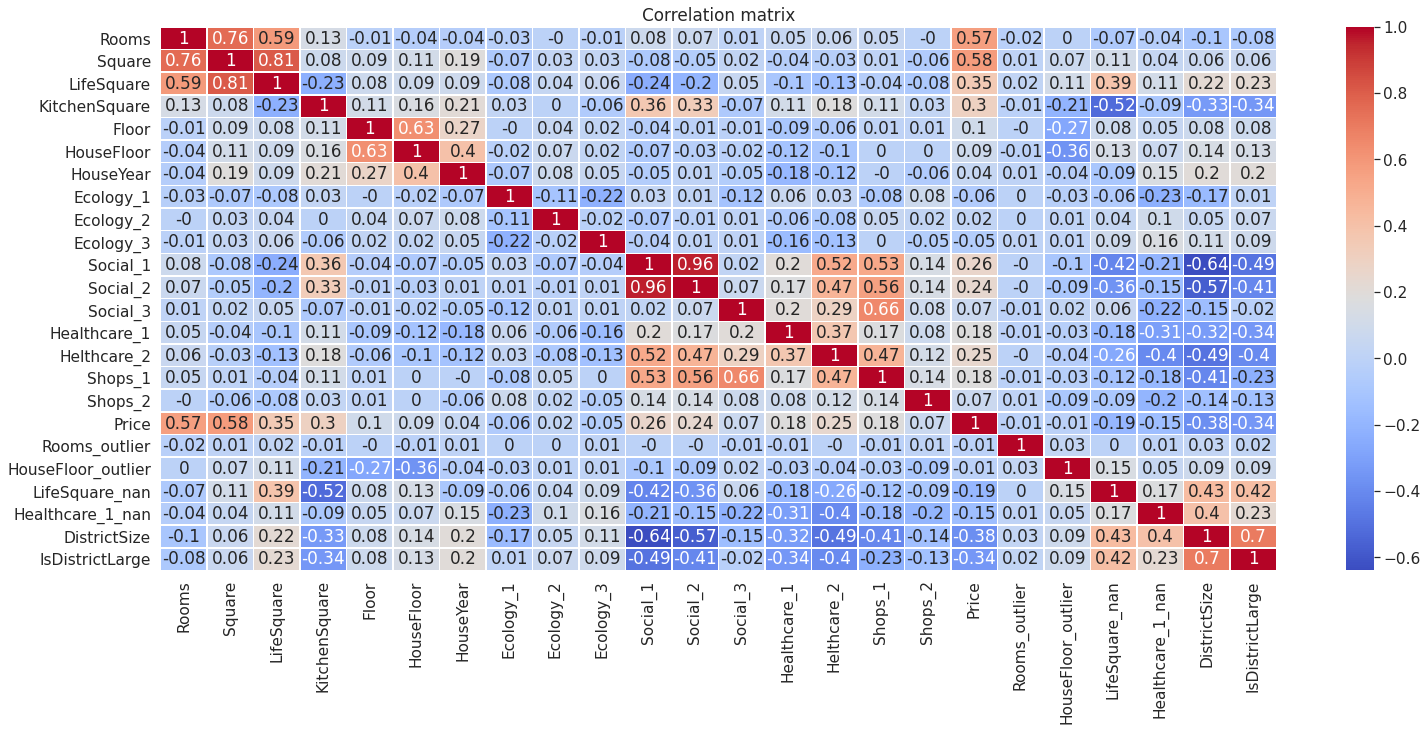

In [64]:
plt.figure(figsize=(25,10))
sns.set(font_scale=1.4)
X_corr = train_df.corr()
X_corr = np.round(X_corr, 2)
sns.heatmap(X_corr, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Из корреляционной матрицы видно, что между комнатами и площадью довольно сильная зависимость (риск влияния на модель в части переобучения)

**MedPriceByDistrict**

In [65]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [66]:
med_price_by_district.shape

(667, 3)

In [67]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,1,305018.871089,0,0,1,1,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,1,177734.553407,0,0,0,0,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,1,282078.720850,0,0,0,0,652,1,244005.272380
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,1,1,168106.007630,0,0,1,1,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,6,1,343995.102962,0,0,0,1,89,0,201584.441255


**MedPriceByFloorYear**

In [68]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [X['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

def square_to_cat_pandas(X):
    bins = [X['Square'].min()-1, 30, 40, 60, 80, 100, X['Square'].max()]
    X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
    
    X['square_cat'].fillna(-1, inplace=True)
    return X

In [69]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,305018.871089,0,0,1,1,851,1,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,0,0,78,0,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,0,0,652,1,244005.272380,4,1
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,168106.007630,0,0,1,1,652,1,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,0,1,89,0,201584.441255,3,5


In [70]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,374737.658654
1,1,2,322905.044793
2,1,3,429825.896082
3,1,4,274992.472366
4,2,1,467230.539057


In [71]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,1,1,851,1,213530.788443,6,2,163047.087076
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,78,0,146032.829834,3,3,192048.442631
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0,652,1,244005.272380,4,1,201919.865889
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,0,1,1,652,1,146735.671740,3,4,183445.443721
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,1,89,0,201584.441255,3,5,171503.249613


**MedYearByDistrict**

Попытка создать показатель зависимости года постройки домов от района

In [72]:
med_year_by_district = train_df.groupby(['DistrictId'], as_index=False).agg({'year_cat':'median'}).\
                                            rename(columns={'year_cat':'MedYearByDistrict'})
med_year_by_district

,DistrictId,MedYearByDistrict
0,0,3.0
1,1,3.0
2,10,3.0
3,100,3.0
4,101,3.0
...,...,...
200,95,3.0
201,96,5.0
202,97,3.0
203,98,3.0


In [73]:
train_df = train_df.merge(med_year_by_district, on=['DistrictId'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,MedYearByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,1,1,851,1,213530.788443,6,2,163047.087076,3.0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,78,0,146032.829834,3,3,192048.442631,3.0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,652,1,244005.272380,4,1,201919.865889,3.0
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,1,1,652,1,146735.671740,3,4,183445.443721,3.0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,1,89,0,201584.441255,3,5,171503.249613,3.0


**MedPriceBySquareFloor**
Попытка создать показатель на основе связки площади квартиры и этажа. Не самая лучшая связка, возможно, но все-таки люди отдают предпочтение определенным этажам и квартиры могут стоить больше на этих этажах

In [74]:
train_df = square_to_cat_pandas(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,MedYearByDistrict,square_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,1,1,851,1,213530.788443,6,2,163047.087076,3.0,5
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,78,0,146032.829834,3,3,192048.442631,3.0,1
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,652,1,244005.272380,4,1,201919.865889,3.0,3
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,1,1,652,1,146735.671740,3,4,183445.443721,3.0,2
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,1,89,0,201584.441255,3,5,171503.249613,3.0,3


In [75]:
med_price_by_square_floor = train_df.groupby(['square_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquareFloor'})
med_price_by_square_floor.tail()

,square_cat,floor_cat,MedPriceBySquareFloor
25,5,1,268394.744389
26,5,2,427650.361241
27,5,3,416188.701892
28,5,4,415837.176502
29,5,5,402234.341723


In [76]:
train_df = train_df.merge(med_price_by_square_floor, on=['square_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,MedYearByDistrict,square_cat,MedPriceBySquareFloor
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,1,851,1,213530.788443,6,2,163047.087076,3.0,5,427650.361241
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,78,0,146032.829834,3,3,192048.442631,3.0,1,164876.852487
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,652,1,244005.272380,4,1,201919.865889,3.0,3,211118.110918
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,1,652,1,146735.671740,3,4,183445.443721,3.0,2,180928.263574
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,89,0,201584.441255,3,5,171503.249613,3.0,3,216806.329764


**Попытка создать комплексный показатель социально-экономических характеристик**

In [77]:
train_df['Ecology_3'].value_counts()

1    9725
0     275
Name: Ecology_3, dtype: int64

In [78]:
train_df['Helthcare_2'].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

In [79]:
train_df['Shops_1'].value_counts()

0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: Shops_1, dtype: int64

In [80]:
med_price_by_social = train_df.groupby(['Ecology_3', 'Helthcare_2', 'Shops_1'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySocial'})
med_price_by_social.tail()

,Ecology_3,Helthcare_2,Shops_1,MedPriceBySocial
54,1,5,5,344183.239861
55,1,5,7,211958.677387
56,1,5,8,198633.629010
57,1,5,15,228453.854181
58,1,6,6,201222.824645


In [81]:
med_price_by_social.shape

(59, 4)

In [82]:
train_df = train_df.merge(med_price_by_social, on=['Ecology_3', 'Helthcare_2', 'Shops_1'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,MedYearByDistrict,square_cat,MedPriceBySquareFloor,MedPriceBySocial
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,851,1,213530.788443,6,2,163047.087076,3.0,5,427650.361241,150321.860442
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,78,0,146032.829834,3,3,192048.442631,3.0,1,164876.852487,193049.498040
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,652,1,244005.272380,4,1,201919.865889,3.0,3,211118.110918,205880.911849
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,652,1,146735.671740,3,4,183445.443721,3.0,2,180928.263574,173984.472520
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,89,0,201584.441255,3,5,171503.249613,3.0,3,216806.329764,194139.246597


In [83]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_floor_year = None
        self.med_price_by_square_floor = None
        self.med_year_by_district = None
        self.med_price_by_social = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        self.square_max = None
        self.square_min = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        
        
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        self.square_max = df['Square'].max()
        self.square_min = df['Square'].min() - 1
        df = self.square_to_cat(df)
        
        ## floor, year, square
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
            self.med_price_by_square_floor = df.groupby(['square_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquareFloor'})
            self.med_price_by_square_floor_median = self.med_price_by_square_floor['MedPriceBySquareFloor'].median()
            
            # MedPriceBySocial
            self.med_price_by_social = df.groupby(['Ecology_3', 'Helthcare_2', 'Shops_1'], as_index=False).agg({'Price':'median'}).\
                                                rename(columns={'Price':'MedPriceBySocial'})
            self.med_price_by_social_median = self.med_price_by_social['MedPriceBySocial'].median()

        
        # MedYearByDistrict
        self.med_year_by_district = df.groupby(['DistrictId'], as_index=False).agg({'year_cat':'median'}).\
                                            rename(columns={'year_cat':'MedYearByDistrict'})
        self.med_year_by_district_median = self.med_year_by_district['MedYearByDistrict'].median()
        
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
               
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        X = X.merge(self.med_year_by_district, on=['DistrictId'], how='left')
        X['MedYearByDistrict'].fillna(self.med_year_by_district_median, inplace=True)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        X = self.square_to_cat(X)
        
        # Target encoding
        if self.med_price_by_square_floor is not None:
            X = X.merge(self.med_price_by_square_floor, on=['square_cat', 'floor_cat'], how='left')
            X['MedPriceBySquareFloor'].fillna(self.med_price_by_square_floor_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
            
        if self.med_price_by_social is not None:
            X = X.merge(self.med_price_by_social, on=['Ecology_3', 'Helthcare_2', 'Shops_1'], how='left')
            X['MedPriceBySocial'].fillna(self.med_price_by_social_median, inplace=True)
            
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
    
    def square_to_cat(self, X):
        bins = [self.square_min, 30, 40, 60, 80, 100, self.square_max]
        X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
    
        X['square_cat'].fillna(-1, inplace=True)
        return X

### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

In [84]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'Healthcare_1_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear',
 'MedYearByDistrict',
 'square_cat',
 'MedPriceBySquareFloor',
 'MedPriceBySocial']

In [85]:
feature_names = ['Square', 'Rooms', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2'] # 'Square', 'Rooms'

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge', 'MedPriceByFloorYear', 'MedYearByDistrict',
                    'MedPriceBySquareFloor', 'MedPriceBySocial']

target_name = 'Price'

### 6. Разбиение на train и test  <a class='anchor' id='split'>

In [108]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [109]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [110]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 24), (3300, 24), (5000, 24))

In [111]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 34), (3300, 34), (5000, 34))

In [112]:
X_train['floor_cat']

0       4.0
1       0.0
2       3.0
3       0.0
4       1.0
       ... 
6695    0.0
6696    3.0
6697    0.0
6698    1.0
6699    1.0
Name: floor_cat, Length: 6700, dtype: float64

In [90]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [91]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [92]:
test_df.head()

,Square,Rooms,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByFloorYear,MedYearByDistrict,MedPriceBySquareFloor,MedPriceBySocial
0,36.847630,1.0,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,0,0,0,76.0,0,0,188612.297808,2.0,160422.790532,208374.223714
1,42.493907,1.0,29.493907,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,164.0,0,1,181679.665945,2.0,193643.813069,151646.107779
2,59.463678,2.0,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,0,0,1,580.0,0,1,172391.237192,2.0,168983.670745,173984.472520
3,49.646030,3.0,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,0,0,0,372.0,0,1,180398.218571,2.0,183490.324647,151646.107779
4,53.837056,1.0,47.837056,3.0,8,17.0,1977,0.309479,1,1,...,0,0,1,65.0,0,0,192658.547447,3.0,193643.813069,194139.246597


In [107]:
test_df['floor_cat']

KeyError: 'floor_cat'

### 7. Построение модели  <a class='anchor' id='modeling'>

In [93]:
from lightgbm import LGBMRegressor

l_m = LGBMRegressor(n_estimators=100, num_leaves=25, max_depth=50)
l_m.fit(X_train, y_train)

LGBMRegressor(max_depth=50, num_leaves=25)

In [94]:
l_m.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 50,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 25,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Train R2:	0.858
Test R2:	0.754


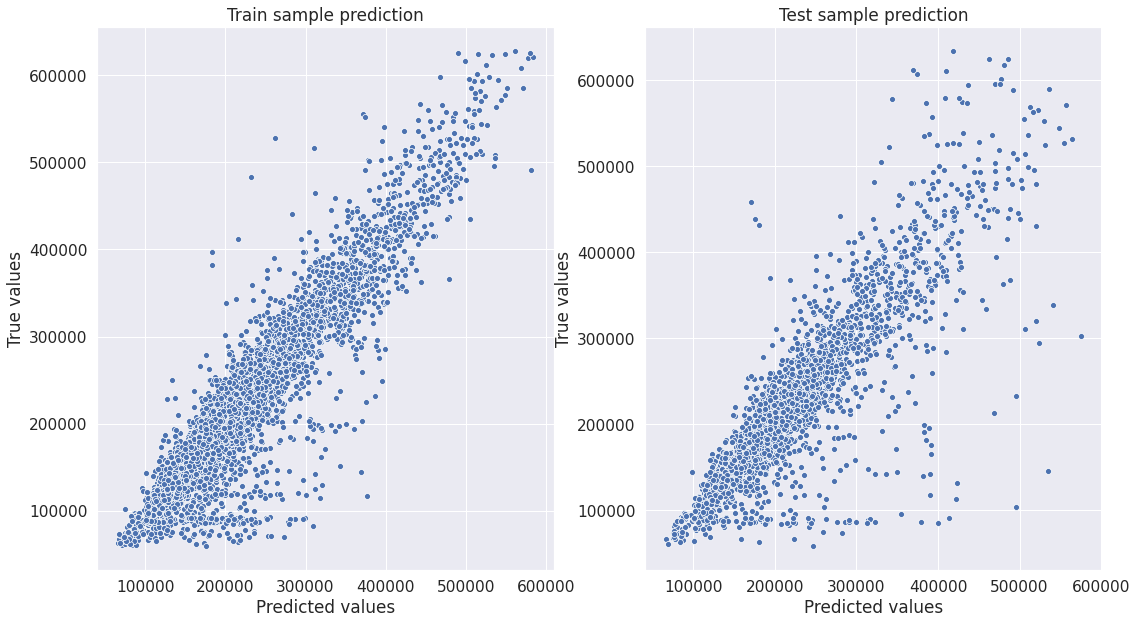

In [95]:
y_train_preds = l_m.predict(X_train)
y_test_preds = l_m.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [96]:
cv_score = cross_val_score(l_m, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.7347873 , 0.69419903, 0.74068654])

In [97]:
from xgboost.sklearn import XGBRegressor

x_m = XGBRegressor(n_estimators=100, max_depth=4)
x_m.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Train R2:	0.883
Test R2:	0.739


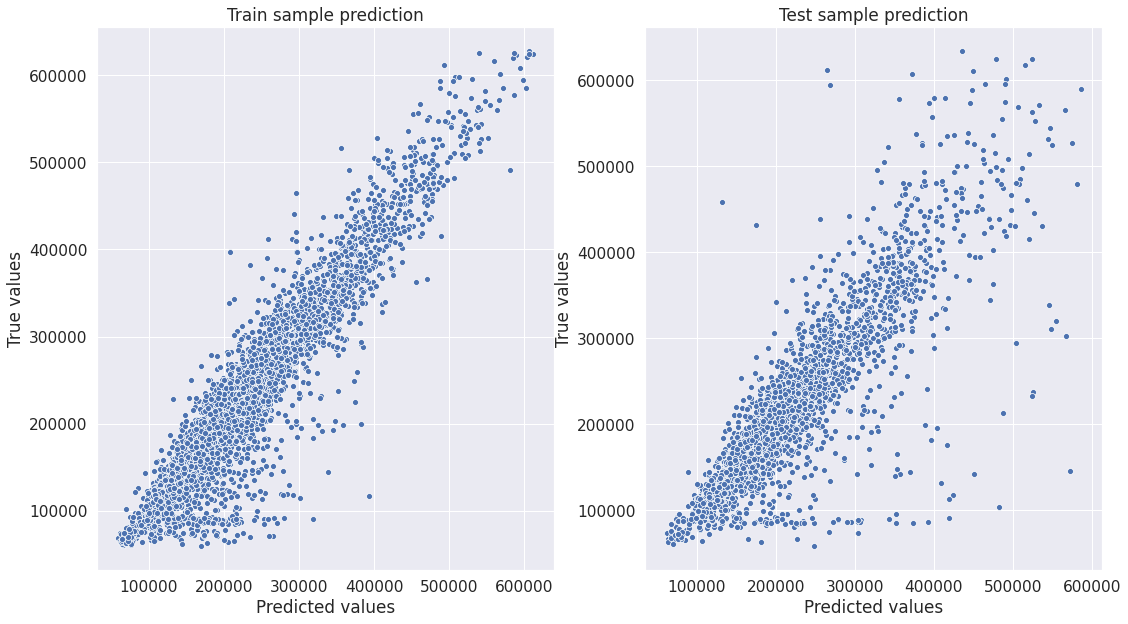

In [98]:
y_train_preds = x_m.predict(X_train)
y_test_preds = x_m.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [99]:
cv_score = cross_val_score(x_m, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.71640656, 0.68778171, 0.72211798])

**Обучение**

In [100]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

**Оценка модели**

Train R2:	0.96
Test R2:	0.75


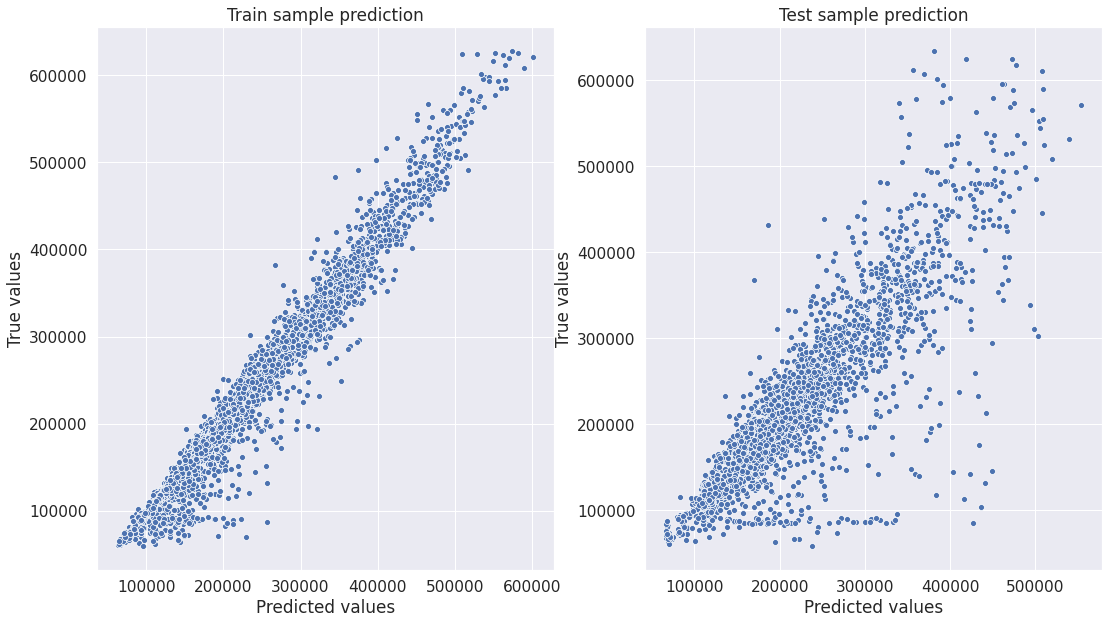

In [101]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [102]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.73033344, 0.67282145, 0.73148052])

In [103]:
cv_score.mean()

0.7115451380771237

**Важность признаков**

In [104]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
0,Square,0.404523
21,DistrictSize,0.211827
12,Social_3,0.044360
27,MedPriceBySocial,0.040710
2,LifeSquare,0.035239
1,Rooms,0.032993
6,HouseYear,0.027689
24,MedPriceByFloorYear,0.025840
7,Ecology_1,0.024865
11,Social_2,0.022793


Идея более сложных моделей:

catboost, lightgbm, xgboost

In [105]:
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
gb = GradientBoostingRegressor()
bg = BaggingRegressor()

stack = StackingRegressor([('lr', lr), ('rf', rf_model), ('l_m', l_m), ('x_m', x_m)], estimators=bg)
stack.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [ ]:
test_df.shape

In [ ]:
test_df

In [ ]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

In [ ]:
predictions = stack.predict(test_df)
predictions

In [ ]:
submit['Price'] = predictions
submit.head()

In [ ]:
submit.to_csv('stack_submit.csv', index=False)